In [1]:
from IPython.display import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))

# 6.5 여러 가지 성능 평가 지표
* 정밀도, 재현율, F1-점수


### 6.5.1 오차 행렬
* 오차 행렬 : 학습 알고리즘의 성능 행렬
    * TP(True Positive)
    * TN(True Negative)
    * FP(False Positive)
    * FN(False Nagative)

* 사이킷런의 confusion_matrix 함수

In [2]:
Image(url='https://git.io/JtsT1', width=300) 

In [3]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_test, y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


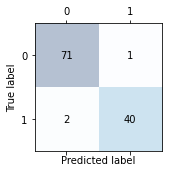

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

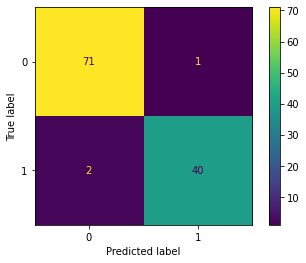

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(pipe_svc, X_test, y_test)
plt.show()

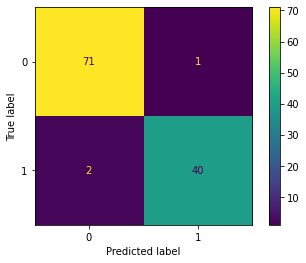

In [6]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

plt.show()

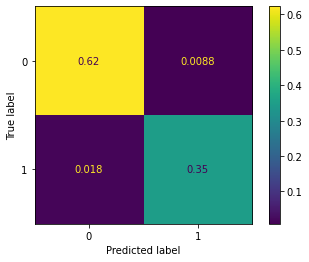

In [7]:
# normalize 매개변수를 사용하여 오차 행렬의 값을 정규화.
# normalize='all' 지정 시 전체 출력 값을 정규화한다.
ConfusionMatrixDisplay.from_estimator(pipe_svc, X_test, y_test,
                                      normalize='all')
plt.show()

### 6.5.2 분류 모델의 정밀도와 재현율 최적화
* 오차 : 잘못된 예측의 합을 전체 예측 샘플 개수로 나눈 것

    $ERR = \dfrac{FP+FN}{FP+FN+TP+TN}$ 

* 정확도 : 옳은 예측의 합을 전체 예측 샘플 개수로 나눈 것

    $ACC = \dfrac{TP+TN}{FP+FN+TP+TN}=1-ERR$

* 진짜 양성 비율(True Positive Rate, TPR) = $TPR=\dfrac{TP}{P}=\dfrac{TP}{FN+TP}$
* 거짓 양성 비율(False Positive Rate, FPR) = $FPR=\dfrac{FN}{N}=\dfrac{EP}{FP+TN}$

* $정밀도(PRE) = \dfrac{TP}{TP + FP}$

* $재현율(REC) = \dfrac{TP}{FN + TP}$

* $F1 = 2 \times \dfrac{정밀도 \times 재현율}{정밀도 + 재현율}$




In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

def evaluation(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: %.4f' % accuracy_score(y_test, y_pred))
    print('정밀도: %.4f' % precision_score(y_test, y_pred))
    print('재현율: %.4f' % recall_score(y_test, y_pred))
    print('F1 스코어: %.4f' % f1_score(y_test, y_pred))

In [9]:
evaluation(y_test, y_pred)

오차 행렬
[[71  1]
 [ 2 40]]
정확도: 0.9737
정밀도: 0.9756
재현율: 0.9524
F1 스코어: 0.9639


GridSearchCV의 scoring 매개변수를 사용하여 정확도 대신 다른 성능 지표를 사용할 수 있다. 

사이킷런에서 양성 클래스는 레이블이 1인 클래스이다. 양성 레이블을 바꾸고싶다면 make_socrer 함수를 사용하여 자신만의 함수를 만들 수 있다. 그 다음 GridSearchCV의 scoring 매개변수에 전달할 수 있다.

In [10]:
# f1_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

scorer = make_scorer(f1_score, pos_label=0)
c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'svc__C': c_gamma_range, 'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range, 'svc__gamma': c_gamma_range, 'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


### 6.5.3 ROC 곡선
* ROC(Receiver Operating Characteristic) 그래프
    * 분류기의 임계 값을 바꾸어 가며 계산된 FPR과 TPR 점수를 기반으로 분류 모델을 선택
    * ROC 그래프의 대각선은 랜덤 추축으로 해석할 수 있고 대각선 아래에 위치한 분류 모델은 랜덤 추출보다 나쁜 것이다.
        * 완벽한 분류기의 그래프는 TPR이 1이고 FPR이 0인 왼쪽 위 구석에 위치.
    * ROC 곡선의 아래 면적인 ROC AUC(ROC Area Under the Curve)를 계산하여 분류 모델의 성능을 종합.
        * ROC AUC : 분류 모델의 확률 임계값을 바꾸어 가며 정밀도-재현율 곡선을 그릴 수 있다.
        

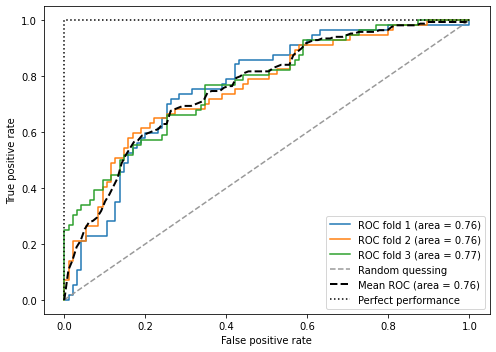

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from numpy import interp
import numpy as np

pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2),
                        LogisticRegression(penalty='l2',  random_state=1, C=100.0))
X_train2 = X_train[:, [4, 14]]
cv = list(StratifiedKFold(n_splits=3, shuffle=True, random_state=1).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random quessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

* 평균 ROC AUC(0.76)는 완벽한 경우(1.0)와 랜덤 추축(0.5) 사이에 있다.

사이킷런 0.22 버전에서 `plot_roc_curve()` 함수와 `plot_precision_recall_curve()` 함수를 사용하면 ROC 곡선과 정밀도-재현율 곡선을 쉽게 그릴 수 있습니다.

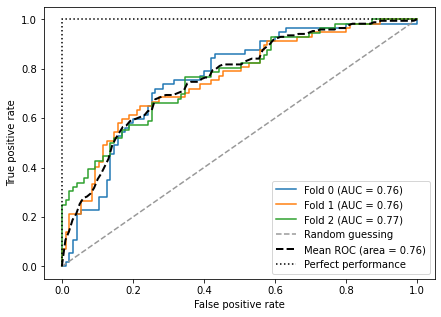

In [12]:
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    pipe_lr.fit(X_train2[train], y_train[train])
    roc_disp = RocCurveDisplay.from_estimator(pipe_lr, X_train2[test], y_train[test], name=f'Fold {i}', ax=ax)
    mean_tpr += interp(mean_fpr, roc_disp.fpr, roc_disp.tpr)
    mean_tpr[0] = 0.0

plt.plot([0, 1], [0, 1],
         linestyle='--', color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0, 0, 1], [0, 1, 1],
         linestyle=':', color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.show()

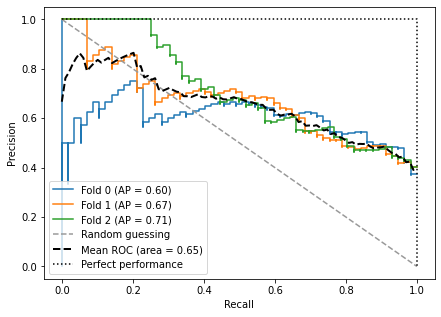

In [13]:
from sklearn.metrics import PrecisionRecallDisplay

fig, ax = plt.subplots(figsize=(7, 5))

mean_precision = 0.0
mean_recall = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    pipe_lr.fit(X_train2[train], y_train[train])
    pr_disp = PrecisionRecallDisplay.from_estimator(
        pipe_lr, X_train2[test], y_train[test], 
        name=f'Fold {i}', ax=ax)
    mean_precision += interp(mean_recall, pr_disp.recall[::-1], 
                             pr_disp.precision[::-1])

plt.plot([0, 1], [1, 0],
         linestyle='--', color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_precision /= len(cv)
mean_auc = auc(mean_recall, mean_precision)
plt.plot(mean_recall, mean_precision, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0, 1, 1], [1, 1, 0],
         linestyle=':', color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.show()

### 6.5.4 다중 분류의 성능 지표
* 사이킷런은 평가 지표에 마크로(macro)와 마이크로(micro) 평균 방식을 구현하여 OvA 방식을 사용하는 다중 분류로 확장한다.
* 마이크로 평균은 클래스별로 TP, TN, FP, FN을 계산

* k개의 클래스가 있는 경우

정밀도의 마이크로 평균

$PRE_{micro} = \dfrac{TP_1+\cdots+TP_k}{TP_1+\cdots+TP_k+FP_1+\cdots+FP_k}$ 

마크로 평균은 단순하게 클래스별 정밀도의 평균

$PRE_{macro} = \dfrac{PRE_1+\cdots+PRE_k}{k}$

마이크로 평균은 각 샘플이나 예측에 동일한 가중치를 부여하고자 할 때 사용한다. 마크로 평균은 모든 클래스에 동일한 가중치를 부여하여 분류기의 전반적인 성능을 평가한다. 이 방식에서는 가장 빈도 높은 클래스 레이블의 성능이 중요하다.

$PRE_{weighted} = \dfrac{PRE_1 \times n_1+\cdots+PRE_k \times n_k}{n}$

$PRE_{samples} = \dfrac{PRE_1+\cdots+PRE_n}{n}$

In [14]:
# average 기본값 'binary'
pre_scorer = make_scorer(score_func=precision_score,
                         pos_label=1,
                         greater_is_better=True,
                         average='micro')
pre_scorer

make_scorer(precision_score, pos_label=1, average=micro)

# 6.6 불균형한 클래스 다루기
* 불균형 클래스
    * 스팸 필터링, 부정 감지, 질병 차단 등


In [15]:
# 불균형 데이터셋
# 212개의 악성 종양(클래스 1)과 357개의 양성 종양(클래스 0)을 가진 유방암 데이터셋
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

위 코드에서 357개의 양성 종양 샘플 전체와 40개의 악성 종양 샘플을 연결하여 불균형이 심한 데이터셋을 만들었다. 무조건 다수 클래스(양성 종양의 클래스 0)를 예측하는 모델은 거의 90%의 정확도를 달성할 것이다.

In [16]:
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

이러한 데이터셋에 분류 모델을 훈련할 때 모델을 비교하기 위해 정확도를 사용하느 것보다 다른 지표를 활용하는 것이 낫다. 애플리케이션에서 주요 관심 대상이 무엇인지에 따라 정밀도, 재현율, ROC 곡선 등을 사용할 수 있다.

* ex)
    * 추가적인 검사가 필요한 악성 종양 환자의 대부분 구별하는 것이 가장 중요하다. => 재현율 지표
    * 스팸 필터의 경우 햄 이머엘이 너무 자주 스팸으로 처리되는 것을 원하지 않는다. => 정밀도 지표

머신 러닝 모델을 평가하는 것과 별개로 클래스 불균형은 모델이 훈련되는 동안 학습 알고리즘 자체에 영향을 미친다. 머신러닝 알고리즘이 일반적으로 훈련하는 동안 처리한 샘플에서 계산한 보상 또는 비용 함수의 합을 최적화한다. 결정 규칙은 다수 클래스 쪽으로 편향되기 쉽다.

* 알고리즘이 훈련 과정에서 비용을 최소화하거나 보상을 최대화하기 위해 데이터셋에서 가장 빈도가 높은 클래스의 예측을 최적화하는 모델을 학습

* 모델이 훈련하는 동안 불균형한 클래스를 다루는 방법
    * 소수 클래스에서 발생한 예측 오류에 큰 벌칙 부여
        * 대부분의 분류기에 규현된 class_weight 매개변수를 class_weight='balanced'로 설정해 벌칙을 편리하게 조정할 수 있다.

* 불균형한 클래스를 다루는 전략
    * 소수 클래스의 샘플을 늘리거나 다수 클래스의 샘플을 줄이거나 인공적으로 훈련 샘플을 생성.

사이킷런 라이브러리는 데이터셋에서 중복을 허용한 샘플 추출 방식으로 소수 클래스의 샘플을 늘리는 데 사용할 수 있는 **resample 함수**를 제공.


In [17]:
# 위스콘신 유방암 데이터셋에서 소수 클래스(클래스 1)를 선택하여 
# 클래스 레이블 0인 샘플 개수와 동일할 때까지 새로운 샘플을 반복적으로 추출
from sklearn.utils import resample

print('샘플링 전 클래스 1의 샘플 개수:', X_imb[y_imb == 1].shape[0])

X_upsampled, y_upsampled = resample(X_imb[y_imb == 1],
                                    y_imb[y_imb == 1],
                                    replace=True,
                                    n_samples=X_imb[y_imb==0].shape[0], random_state=123)

print('샘플링 후 클래스 1의 샘플 개수:', X_upsampled.shape[0])

샘플링 전 클래스 1의 샘플 개수: 40
샘플링 후 클래스 1의 샘플 개수: 357


In [18]:
# 샘플을 추출한 후 클래스 0인 원본 샘플과 업샘플링된 클래스 1을 연결하여 균형 잡힙 데이터셋을 얻을 수 있다.
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

# 위에서 다수 클래스로 예측하는 규칙은 50% 정확도로 나온다
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0

비슷하게 데이터셋에서 다수 클래스의 훈련 샘플을 삭제하여 다운샘플링(downsampling)할 수 있다. resample 함수를 사용하여 다운 샘플링하려면 클래스 레이블을 서로 바꾸면 된다.

#### 클래스 불균형 문제를 해결하기 위해 새로운 훈련 데이터 생성
* 인공적인 훈련 샘플 생성 - SMOTE(Synthetic Minority Over-sampling TEchnique)
* 불균형한 데이터셋을 위한 파이썬 라이브러리인 imbalanced-learn
* https://github.com/scikit-learn-contrib/imbalanced-learn